In [1]:
import FlockModel
import importlib
import numpy as np
import matplotlib.pyplot as plt

Viscek:
Stated briefly as rules, and in $\textbf{order of decreasing precedence}$, the behaviors that lead to simulated flocking are:
1. Collision Avoidance: avoid collisions with nearby
flockmates
2. Velocity Matching: attempt to match velocity with nearby
flockmates
3. Flock Centering: attempt to stay close to nearby flockmates 

In [ ]:
phenotypes = ["4"]
angles = [np.pi, np.pi/2, np.pi/3, np.pi/4]

for angle in angles:
    for phenotype in phenotypes:
        model = Model(dt = 0.1, maxtime = 100, noise = 0.01, phenotype = phenotype, angle = angle)
        model.run(), 
        model.animate(name = str(phenotype) + str(angle))

${\displaystyle \operatorname {distance} (P_{1},P_{2},(x_{0},y_{0}))={\frac {|(x_{2}-x_{1})(y_{1}-y_{0})-(x_{1}-x_{0})(y_{2}-y_{1})|}{\sqrt {(x_{2}-x_{1})^{2}+(y_{2}-y_{1})^{2}}}}.}$

# Create CSV of positions for blender (TEST)

In [49]:
phenotypes = ["1", "2", "3", "4", "5", "6", "7", "8", "Viscek", "Random"]
for phenotype in phenotypes:

    model = Model(dt = 0.25, maxtime = 100, noise = 0.01, phenotype = phenotype)
    model.run(), 
    model.blender_csv()

# Connected correlation function test

In [2]:
importlib.reload(FlockModel)

model = FlockModel.Model(dt = 0.5, maxtime = 30, noise = 0.1, phenotype = [0,1,0], density=1)
model.run()
model.animate(name="correlation_test")
model.order_plot()
model.sus_plot()

43
0
51
0.5
46
1.0
53
1.5
49
2.0
47
2.5
56
3.0
49
3.5
44
4.0
50
4.5
46
5.0
46
5.5
51
6.0
46
6.5
49
7.0
46
7.5
44
8.0
50
8.5
50
9.0
50
9.5
47
10.0
51
10.5
43
11.0
47
11.5
44
12.0
45
12.5
50
13.0
48
13.5
50
14.0
47
14.5
43
15.0
47
15.5
45
16.0
45
16.5
50
17.0
43
17.5
50
18.0
47
18.5
46
19.0


ValueError: attempt to get argmin of an empty sequence

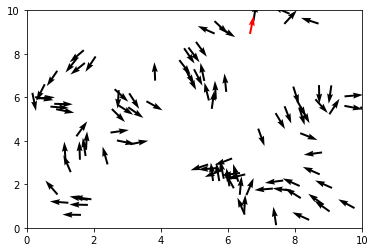

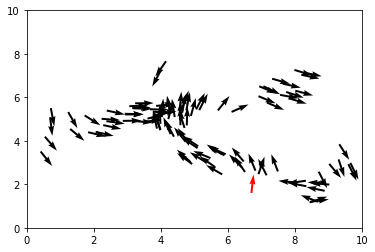

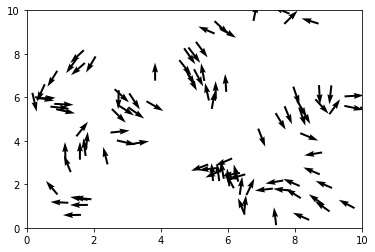

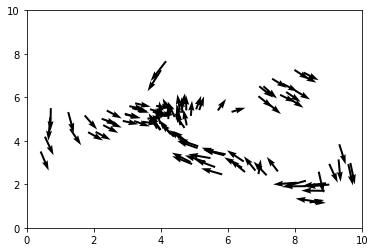

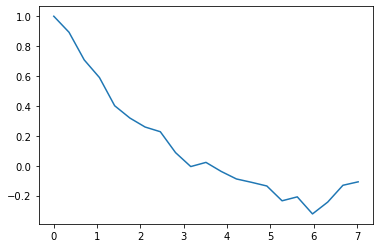

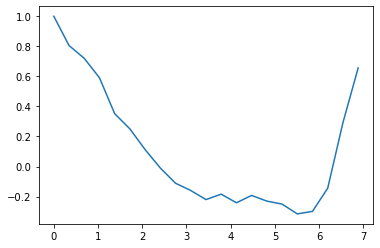

In [4]:
model.quiver_plot(i=3)
model.quiver_plot(i=9)
model.vel_fluc_plot(i=3)
model.vel_fluc_plot(i=9)
model.corr_plot(i=3)
model.corr_plot(i=9)

In [42]:
a = [1,2,3]
k = 1
if k in a:
    print(k)

1


In [33]:
# Get velocities and positions at a certain point
vel = []
dim_vel = []
pos = []
frame = 40

for a in model.agents:
    vel.append(a.vel[frame])
    pos.append(a.pos[frame])

print("Velocities:")
for v in vel:
    print(v)

print()
print("Positions:")
for p in pos:
    print(p)

print()
print("Average velocity")
avg_vel = sum(vel)/len(vel)
print(avg_vel)

print()
print("Dimensionless velocity fluctuation")
denom = sum([np.linalg.norm(v-avg_vel)**2 for v in vel])/len(vel)
dim_vel = [(v-avg_vel)/denom for v in vel]
for v in dim_vel:
    print(v)

Velocities:
[0.80695494 0.59061301]
[0.69689039 0.71717765]
[0.28719597 0.95787185]
[0.89989718 0.43610213]
[0.29207765 0.95639461]
[0.55352216 0.83283445]
[0.20473207 0.97881805]
[0.69031757 0.7235065 ]
[0.77355665 0.63372716]
[0.66926805 0.74302105]
[0.50771867 0.86152293]
[0.90710162 0.42091169]
[0.90046925 0.43491969]
[0.94595657 0.32429334]
[0.76992017 0.63814021]
[0.07154303 0.99743751]
[0.39146409 0.92019338]
[0.76347148 0.64584154]
[0.82676655 0.56254518]
[0.1515762  0.98844557]
[0.98815843 0.15343701]
[0.04477254 0.99899721]
[0.17905957 0.98383823]
[0.12918554 0.99162044]
[0.67269308 0.73992163]
[0.57810595 0.81596171]
[0.33841906 0.9409955 ]
[0.6096163  0.79269664]
[0.12840313 0.99172206]
[0.68117345 0.73212207]
[0.68193809 0.7314099 ]
[0.7318188  0.68149926]
[0.82767268 0.56121114]
[0.83043049 0.55712225]
[0.73951105 0.67314442]
[0.7940842  0.60780777]
[0.81856854 0.57440887]
[0.71200219 0.70217724]
[0.73320611 0.68000647]
[0.76342186 0.64590019]
[0.72277464 0.6910838 ]
[0.8

In [9]:
pred = FlockModel.Predator()
print(pred.update_pos)

<bound method Agent.update_pos of <FlockModel.Predator object at 0x7f58fc695340>>
